## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import optuna

## Configurations


In [2]:
# path for the processed training dataset
train_data_path = 'C:/Users/ansar/Desktop/Workspace/Personal/MLOPs/Customer Churn Prediction/api/src/notebooks/data/train_processed.csv'

SPLIT=0.2
SEED=42
FOLDS=5

In [3]:
# loading the training dataset
df_train = pd.read_csv(train_data_path)

### Handling class imbalance

In [4]:
# separating the independent and dependent features
X_dev = df_train.drop('Churn', axis=1)
y_dev = df_train['Churn']

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=SPLIT, random_state=SEED)

In [6]:
# resampling for class imbalance
smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Model Development

In [7]:
# models for training
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SupportVectorClassifier': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'XGBClassifier': XGBClassifier(),
    'LGBMClassifier': LGBMClassifier(verbose=-1),
    'CatBoostClassifier': CatBoostClassifier(verbose=False)
}

In [8]:
# training and validating models
results = []
for name, model in models.items():

    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_val)

    results.append({
        'Model': name,
        'Recall': recall_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'F1 Score': f1_score(y_val, y_pred)
    })

results_df = pd.DataFrame(results).sort_values('Recall', ascending=False)

In [9]:
results_df

,Model,Recall,Precision,F1 Score
0,LogisticRegression,0.770492,0.524554,0.624170
2,SupportVectorClassifier,0.721311,0.543210,0.619718
1,KNeighborsClassifier,0.718033,0.465957,0.565161
5,GradientBoostingClassifier,0.659016,0.598214,0.627145
8,CatBoostClassifier,0.613115,0.640411,0.626466
7,LGBMClassifier,0.593443,0.613559,0.603333
6,XGBClassifier,0.590164,0.612245,0.601002
3,DecisionTreeClassifier,0.527869,0.503125,0.515200
4,RandomForestClassifier,0.524590,0.581818,0.551724


### Tuning Hyper-Parameters using Optuna

### 1. Logistic Regression

In [10]:
def objective(trial):

    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'newton-cg', 'sag'])

    params = {
        'C': trial.suggest_float('C', 1e-3, 10, log=True),
        'max_iter': trial.suggest_int('max_iter', 1000, 3000),
        'tol': trial.suggest_float('tol', 1e-5, 1e-1, log=True),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 0.1, 10),
        'solver': solver,
        'random_state': SEED,
    }

    if solver == 'liblinear':
        l1_ratio = trial.suggest_categorical('l1_ratio_liblinear', [0.0, 1.0])
        params['l1_ratio'] = l1_ratio
    
    elif solver == 'saga':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
    
    elif solver in ['lbfgs', 'newton-cg', 'sag']:
        params['l1_ratio'] = 0.0

    model = LogisticRegression(**params)
    score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=FOLDS, scoring='recall').mean()
    return score

In [11]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f'Best Parameters: {study.best_params}')

[I 2026-02-06 11:37:36,227] A new study created in memory with name: no-name-4860a65c-4468-4829-8926-50176def3fa5
[I 2026-02-06 11:37:36,354] Trial 0 finished with value: 0.821482309327809 and parameters: {'solver': 'lbfgs', 'C': 0.2615827730767953, 'max_iter': 1272, 'tol': 0.0015388723813410743, 'class_weight': 'balanced', 'fit_intercept': False, 'intercept_scaling': 9.724417753132451}. Best is trial 0 with value: 0.821482309327809.
[I 2026-02-06 11:37:36,555] Trial 1 finished with value: 0.8211824674262662 and parameters: {'solver': 'lbfgs', 'C': 0.1306087667376905, 'max_iter': 2866, 'tol': 1.3644797691857113e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'intercept_scaling': 6.059860991671946}. Best is trial 0 with value: 0.821482309327809.
[I 2026-02-06 11:37:39,010] Trial 2 finished with value: 0.8248005597048829 and parameters: {'solver': 'sag', 'C': 1.122539176500746, 'max_iter': 1062, 'tol': 0.00010835505646596126, 'class_weight': 'balanced', 'fit_intercept': True, 'i

Best Parameters: {'solver': 'sag', 'C': 0.30488401774858853, 'max_iter': 1311, 'tol': 0.07272504817997558, 'class_weight': None, 'fit_intercept': True, 'intercept_scaling': 0.2339737361256624}


In [12]:
# validating the tuned logistic regression model
best_params = study.best_params

# clean the param names
if 'l1_ratio_liblinear' in best_params:
    best_params['l1_ratio'] = best_params.pop('l1_ratio_liblinear')

final_model = LogisticRegression(**best_params, random_state=SEED)
final_model.fit(X_train_resampled, y_train_resampled)

y_pred = final_model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       822
           1       0.53      0.76      0.63       305

    accuracy                           0.75      1127
   macro avg       0.71      0.76      0.72      1127
weighted avg       0.80      0.75      0.76      1127



In [13]:
# helper function for plotting ROC curve
def plot_roc(classifier, fpr, tpr, auc_score):
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{classifier} (AUC={auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.grid(True, alpha=0.3)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {classifier}')
    plt.legend()
    plt.show()

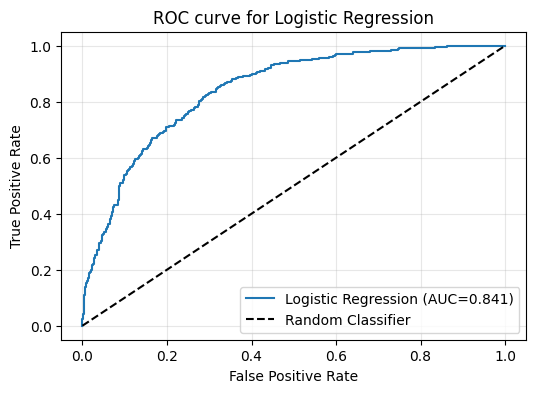

In [14]:
# plotting ROC curve
y_prob = final_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
auc_score = roc_auc_score(y_val, y_prob)

plot_roc('Logistic Regression', fpr, tpr, auc_score)

### 2. Support Vector Classifier

In [15]:
def objective(trial):

    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
    
    params = {
        'C': trial.suggest_float('C', 1e-3, 100, log=True),
        'kernel': kernel,
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': SEED,
    }
    
    if kernel == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 5)
        params['coef0'] = trial.suggest_float('coef0', 0.0, 10.0)
    
    elif kernel in ['sigmoid', 'poly']:
        params['coef0'] = trial.suggest_float('coef0', 0.0, 10.0)
    
    model = SVC(**params)
    score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=FOLDS, scoring='recall').mean()
    return score

In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f'Best Parameters: {study.best_params}')

[I 2026-02-06 11:47:08,477] A new study created in memory with name: no-name-939a5387-514c-4e1a-8706-099540b477da
[I 2026-02-06 11:47:19,678] Trial 0 finished with value: 0.7665158371040723 and parameters: {'kernel': 'sigmoid', 'C': 11.526625961424166, 'gamma': 'auto', 'class_weight': None, 'coef0': 6.732421890986081}. Best is trial 0 with value: 0.7665158371040723.
[I 2026-02-06 11:47:29,400] Trial 1 finished with value: 0.8618914572316415 and parameters: {'kernel': 'sigmoid', 'C': 2.365200530013478, 'gamma': 'auto', 'class_weight': 'balanced', 'coef0': 3.0707460711820964}. Best is trial 1 with value: 0.8618914572316415.
[I 2026-02-06 11:47:34,568] Trial 2 finished with value: 0.8371626778607644 and parameters: {'kernel': 'poly', 'C': 0.04680340402985607, 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4, 'coef0': 5.9418469834740115}. Best is trial 1 with value: 0.8618914572316415.
[I 2026-02-06 11:47:46,143] Trial 3 finished with value: 0.7861236802413274 and parameters: {'ker

Best Parameters: {'kernel': 'sigmoid', 'C': 99.02844274244312, 'gamma': 'scale', 'class_weight': 'balanced', 'coef0': 5.929050096703457}


In [20]:
# validating the tuned support vector classifier model
best_params = study.best_params

final_model = SVC(**best_params, probability=True, random_state=SEED)
final_model.fit(X_train_resampled, y_train_resampled)

y_pred = final_model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.45      0.61       822
           1       0.39      0.95      0.55       305

    accuracy                           0.59      1127
   macro avg       0.68      0.70      0.58      1127
weighted avg       0.81      0.59      0.60      1127



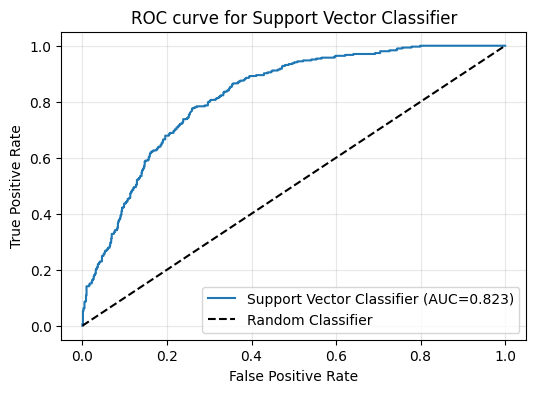

In [21]:
# plotting ROC curve
y_prob = final_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
auc_score = roc_auc_score(y_val, y_prob)

plot_roc('Support Vector Classifier', fpr, tpr, auc_score)

### Model Comparison Results

**Logistic Regression** (AUC: 0.841) wins over **Support Vector Classifier** (AUC: 0.823).

- LR has balanced precision/recall (0.53/0.76) while SVC has extreme 0.95 recall but terrible 0.39 precision (61% false alarms).

- Logistic Regression has fewer false positives while still catching 76% of churners.